
# Retrievals: Basic Retrieval Tutorial




Written by [Evert Nasedkin](mailto:nasedkinevert@gmail.com?subject=[petitRADTRANS]%20Retrievals) and 
Paul Mollière

References:
- [Mollière+ (2019)](https://ui.adsabs.harvard.edu/abs/2019A%26A...627A..67M/abstract)
- [Mollière+ (2020)](https://ui.adsabs.harvard.edu/abs/2020A%26A...640A.131M/abstract)


**What is a retrieval?**

Let's start with the basics! 
An atmospheric retrieval is the process through which we fit a model of a spectrum to data.
The model usually incorporates elements of chemistry and radiative transfer in order to compute a spectrum - see the [getting started page for an example](../getting_started.html).

If you're here, we're going to assume that you already have an exoplanet emission or transmission spectrum, and you want to learn something about the planet's properties. 
We'll use the petitRADTRANS (pRT) package, a 1D atmospheric radiative transfer tool, combined with a sampler which will allow us to statistically measure the properties of the planet of interest. 
As inputs for this, you'll need a 1D spectrum with error bars (or a covariance matrix), and a model function that generates a synthetic spectrum. 
We have a few example datasets included in `petitRADTRANS/retrieval/examples/`, and several forward models implemented in `petitRADTRANS/retrieval/models.py`, which you can use directly, or as templates to build your own model.

In this example we will make use of an HST transmission spectrum, located locally in `petitRADTRANS/retrieval/examples/transmission/observations/HST/hst_example_clear_spec.txt`, or [online](https://gitlab.com/mauricemolli/petitRADTRANS/-/tree/master/petitRADTRANS/retrieval/examples/transmission/observations/HST/hst_example_clear_spec.txt). This dataset is included when you install pRT, and we'll automatically locate the data and output files throughout the notebook.
The outputs of the retrieval example will be a best-fit spectrum, an atmospheric pressure-temperature profile, and the posterior distributions of all of the parameters of your model atmosphere.
Of course, you do not have to use pRT's retrieval package to run retrievals with pRT-generated spectra, but we believe that what is described below may be sufficient for most people, and will thus save you from most of the tedious implementation work.

## Getting started


You should already have an installation of pRT on your machine, please see the [installation manual](../installation.html) if you have not installed it yet. 
[pyMultiNest](https://github.com/JohannesBuchner/PyMultiNest) - and therefore [Multinest](https://github.com/JohannesBuchner/MultiNest) is also required. 
`Multinest` allows for easy scaling of the retrievals to run on large clusters, but can also be installed locally on your laptop to run small retrievals, such as this example.
[Ultranest](https://johannesbuchner.github.io/UltraNest/index.html) is required if you want to use that as your sampler rather than pyMultiNest. 
See the Ultranest documentation for why you might want to choose this method.
Using nested sampling rather than MCMC is faster, handles multimodal cases better, and directly provides the Bayesian evidence, which allows for easier model comparison. 
However, we've found that in general pyMultinest is faster than Ultranest, and generally recommend its use.

In this tutorial, we will outline the process of setting up a RetrievalConfig object, which is the class used to set up a pRT retrieval.
The basic process will always be to set up the configuration, and then pass it to the Retrieval class to run the retrieval using pyMultiNest.
Several standard plotting outputs will also be produced by the retrieval class.
Most of the classes and functions used in this tutorial have more advanced features than what will be explained here, so it's highly recommended to take a look at the code and API documentation. 
There should be enough flexibility built in to cover most typical retrieval studies, but if you have feature requests please get in touch, or open an issue on [gitlab](https://gitlab.com/mauricemolli/petitRADTRANS.git).



In [1]:
# Let's start by importing everything we need.
import os
# To not have numpy start parallelizing on its own
os.environ["OMP_NUM_THREADS"] = "1"

# You may need to set the input data path so that pRT knows where the opacities are stored.
#os.environ["pRT_input_data_path"] = "/u/nnas/packages/petitRADTRANS/petitRADTRANS/input_data/"

import numpy as np
import matplotlib.pyplot as plt

from petitRADTRANS import Radtrans
from petitRADTRANS import nat_cst as nc

# Import the class used to set up the retrieval.
from petitRADTRANS.retrieval import Retrieval,RetrievalConfig
# Import Prior functions, if necessary.
from petitRADTRANS.retrieval.util import gaussian_prior
# Import an atmospheric model function
from petitRADTRANS.retrieval.models import isothermal_transmission

Let's start with a simple model. 
We'll use an isothermal temperature profile, and use free chemistry - allowing the chemical abundances to vary freely within fixed boundaries, but requiring them to be vertically constant throughout the atmosphere.
The basic process for every retrieval will be the same. We need to set up a [`RetrievalConfig`](https://gitlab.com/mauricemolli/petitRADTRANS/-/blob/master/petitRADTRANS/retrieval/retrieval_config.py) object, adding in the [`Data`](https://gitlab.com/mauricemolli/petitRADTRANS/-/blob/master/petitRADTRANS/retrieval/data.py) objects that we want to fit together with the [`Parameter`](https://gitlab.com/mauricemolli/petitRADTRANS/-/blob/master/petitRADTRANS/retrieval/parameter.py) objects and their priors, which we can use to customize our retrieval.


Lets start out by setting up a simple run definition.
We'll add the data AFTER we define the model function below.
We start out by initialising the object, and then adding each of the parameters of interest to the `RetrievalConfig`.
Full details of the parameters can be found in the [API documentation](../../autoapi/petitRADTRANS/retrieval/retrieval_config/index.html).

In [2]:
# Lets start out by setting up a simple run definition
# We'll add the data AFTER we define the model function below
# Full details of the parameters can be found in retrieval_config.py

# Since our retrieval has already ran before, we'll set the mode to 'evaluate' so we can make some plots.
RunDefinition = RetrievalConfig(retrieval_name="hst_example_clear_spec", 
                                run_mode="retrieval",  # this can be 'evaluate' to get the results of a retrieval
                                AMR=False, # We won't be using adaptive mesh refinement for the pressure grid        
                                scattering=False) # This would turn on scattering when calculating emission spectra.
                                                          # Scattering is automatically included for transmission spectra.
    
# Let's start with the parameters that will remain fixed during the retrieval
RunDefinition.add_parameter('Rstar', # name
                             False,   # is_free_parameter, So Rstar is not retrieved here.
                             value = 0.651*nc.r_sun)

# Log of the surface gravity in cgs units.
# The transform_prior_cube argument transforms a uniform random sample x, drawn between 0 and 1.
# to the physical units we're using in pRT.
RunDefinition.add_parameter('log_g',
                             True, # is_free_parameter: we are retrieving log(g) here 
                             transform_prior_cube_coordinate = \
                                lambda x : 2.+3.5*x) # This means that log g
                                                                   # can vary between 2 and 5.5
                                  # Note that logg is usually not a free parameter in retrievals of
                                  # transmission spectra, at least it is much better constrained as being
                                  # assumed here, as the planetary mass and radius are usually known.

# Planet radius in cm
RunDefinition.add_parameter('R_pl', 
                            True,
                            transform_prior_cube_coordinate = \
                                lambda x : ( 0.2+0.2*x)*nc.r_jup_mean) # Radius varies between 0.2 and 0.4

# Interior temperature in Kelvin
RunDefinition.add_parameter('Temperature', 
                            True,
                            transform_prior_cube_coordinate = \
                                lambda x : 300.+2000.*x)

# Let's include a grey cloud as well to see what happens, even though we assumed a clear atmosphere.
RunDefinition.add_parameter("log_Pcloud", 
                            True, 
                            transform_prior_cube_coordinate = \
                                lambda x : -6.0+8.0*x)  # The atmosphere can thus have an opaque cloud
                                                        # between 1e-6 and 100 bar

## Opacities

petitRADTRANS can be setup to use line-by-line opacities at $\lambda/\Delta \lambda = 10^6$, or a lower resolution correlated-k mode (which we use here). The names of each species in these lists much match the names of the pRT opacity data folders. See the standard list [here](../available_opacities.html).

In addition to the line opacities, pRT also accounts for Rayleigh scattering, collision-induced absorption (CIA) opaticies, and opacities for various condensate cloud species. If a cloud species is used, it will have a set of parameters added in order to retrieve the cloud abundance. We give such an example [below](#Emission-Spectrum-Example). The parameters added depend on the model chosen. 

If you aren't sure which species are available, the RetrievalConfig class has a few functions that will list the currently available line, CIA and cloud opacities, see the [API documentation](../../autoapi/petitRADTRANS/retrieval/retrieval_config/index.html).



**exo-k**

If you set the model resolution for your data, and do not have existing c-k tables at that resolution, exo-k will be used to bin the higher resolution tables down to a lower resolution.
_This must be run on a single core._ 
To ensure that the retrieval runs properly, the retrieval will end if exo-k is used, so that the remainder of the retrieval can be restarted and run with multiple cores.
This isn't an elegant solution, and will be improved in a future release.

In [3]:
RunDefinition.list_available_line_species()
RunDefinition.set_rayleigh_species(['H2', 'He'])
RunDefinition.set_continuum_opacities(['H2-H2', 'H2-He'])

# Here we setup the line species for a free retrieval, setting the prior bounds with the abund_lim parameter
# The retrieved value is the log mass fraction.
# RunDefinition.set_line_species(["CH4", "H2O", "CO2", "CO_all_iso"], free=True, abund_lim = (-6.0,0.0))

# Let's use the most up-to-date line lists
RunDefinition.set_line_species(["CH4", "H2O_Exomol", "CO2", "CO_all_iso_HITEMP"], eq=False, abund_lim = (-6.0,0.0))


correlated-k opacities

H2O_Exomol
Ca+
K_burrows
Ca
O+
CO_all_iso_HITEMP
CO_13_HITEMP
K_lor_cut
OH
H2S
V+
TiO_all_Exomol
CO_all_iso_Chubb
TiO_48_Exomol
CO_12_HITEMP
CO_13_Chubb
HCN
CO2
analytics
Si+
CaH
VO
NaH
Ti
Na_allard
SO2
SiO2
TiO_48_Plez
CrH
SH
H2O_HITEMP
Si
PH3
NH3
TiO_all_Plez
O2
VO_Plez
Mg
Al+
SiO
Na_burrows
MgH
V
AlH
Na_lor_cut
Ti+
Al
MgO
FeH
C2H4
Fe
Fe+
Mg+
AlO
O
CH4
O3
C2H2
CO_all_iso
Li
K_allard
H2O

line-by-line opacities

TiO_all_iso
CO_main_iso
VO
TiO_all_iso_exo
H2S_main_iso
K
CO2_main_iso
HCN_main_iso
H2O_main_iso
Na
NH3_main_iso
CH4_main_iso


## Model Functions


In addition to setting up a retrieval with a standard mode, you may also want to write your own model to be used in the retrieval setup. 
`pRT` has a wide range of built in model functions, which we recommend using as opposed to writing your own, but we'll include a simple example here to show what's going on behind the scenes.
For further documentation on the built in models, [check out this tutorial page.](../retrieval_models.html)
This function will be passed as the <code>model_generating_function</code> argument when you <code>add_data</code> to the RetrievalConfig class. Here we will outline a simple, cloud-free transmission spectrum model using free retrieval chemistry and an isothermal P-T profile to demonstrate.

Four parameters are required. 
A pRT object which is created is from the `Radtrans` class in pRT and a dictionary of parameters, which is stored in the RetrievalConfig class that we defined above. The remaining three parameters deal with plotting and adaptive mesh refinement, which we won't use in this example.

In general, the built in model functions require cgs units, apart from pressure which is given in bar.

For this tutorial we are reimplementing a simplified version the `isothermal_transmission` model, available in `petitRADTRANS.retrieval.models`. 

In [4]:
from petitRADTRANS.physics import isothermal
from petitRADTRANS.retrieval.util import calc_MMW, compute_gravity
# Now we can define the atmospheric model we want to use
def retrieval_model_spec_iso(pRT_object, \
                             parameters, \
                             PT_plot_mode = False,
                             AMR = False):
    """
    retrieval_model_eq_transmission
    This model computes a transmission spectrum based on free retrieval chemistry
    and an isothermal temperature-pressure profile. 
    
    parameters
    -----------
    pRT_object : object
        An instance of the pRT class, with optical properties as defined in the RunDefinition.
    parameters : dict
        Dictionary of required parameters:
            Rstar : Radius of the host star [cm]
            log_g : Log of surface gravity
            R_pl : planet radius [cm]
            Temperature : Isothermal temperature [K]
            species : Log abundances for each species used in the retrieval
            log_Pcloud : optional, cloud base pressure of a grey cloud deck.
    PT_plot_mode : bool
        Return only the pressure-temperature profile for plotting. Evaluate mode only.
    AMR : 
        Adaptive mesh refinement. Use the high resolution pressure grid around the cloud base.

    returns
    -------
    wlen_model : np.array
        Wavlength array of computed model, not binned to data [um]
    spectrum_model : np.array
        Computed transmission spectrum R_pl**2/Rstar**2
    """
    contribution = False
    if "contribution" in parameters.keys():
        contribution = parameters["contribution"].value

    # Make the P-T profile
    pressures = pRT_object.press/1e6 # Convert from bar to cgs; internally pRT uses cgs

    # Note how we access the values of the Parameter class objects
    temperatures = isothermal(pressures,parameters['Temperature'].value)
       
    # If in evaluation mode, and PTs are supposed to be plotted
    if PT_plot_mode:
        return pressures, temperatures
    
    # Make the abundance profiles
    abundances = {}
    msum = 0.0 # Check that the total massfraction of all species is <1
    for species in pRT_object.line_species:
        spec = species.split('_R_')[0] # Dealing with the naming scheme
                                       # for binned down opacities (see below).
        abundances[species] = 10**parameters[spec].value * np.ones_like(pressures)
        msum += 10**parameters[spec].value
    if msum > 1.0:
        return None, None

    abundances['H2'] = 0.766 * (1.0-msum) * np.ones_like(pressures)
    abundances['He'] = 0.234 * (1.0-msum) * np.ones_like(pressures)
    
    # Find the mean molecular weight in each layer
    MMW = calc_MMW(abundances)
    
    gravity, R_pl =  compute_gravity(parameters)
    # Calculate the spectrum
    pRT_object.calc_transm(temperatures,
                           abundances,
                           gravity,
                           MMW,
                           P0_bar=0.01,
                           R_pl = R_pl,
                           Pcloud = 10**parameters['log_Pcloud'].value,
                           contribution = contribution)
                           
    # Transform the outputs into the units of our data.
    wlen_model = nc.c/pRT_object.freq/1e-4 # wlen in micron
    spectrum_model = (pRT_object.transm_rad/parameters['Rstar'].value)**2.
    if contribution:
        return wlen_model, spectrum_model, pRT_object.contr_tr
    return wlen_model, spectrum_model

## Data

With the model set up, we can read in the data. The data must be a 1D spectrum with error bars or a covariance matrix.
The input format for ASCII data is
```
# Wavelength [micron], Flux [W/m2/micron or (Rp/Rstar)^2], Flux Error [W/m2/micron or (Rp/Rstar)^2]
```
Optionally, there can also be an additional column to specify the wavelength bins, which would then have the format:
```
# Wavelength [micron], Bins [micron], Flux [W/m2/micron or (Rp/Rstar)^2], Flux Error [W/m2/micron or (Rp/Rstar)^2]
```
The file can be comma or space separated, and by default '#' is the comment character.
The wavelength column must be sorted and is in ascending order.
If you write your own model function, the units of your data can vary from this template, but the units of your data and the output of your model function must match.
Throughout our documentation we will use W/m2/micron for emission spectra and (Rp/Rstar)^2 for consistency between our model functions and the example data.

The fits file requirements are more strict.
An extension labelled 'SPECTRUM' is required, with three fields in a binary table: 'WAVELENGTH', 'FLUX' and 'COVARIANCE'.
An example of this is the `HR8799e_spectra.fits` file included in `petitRADTRANS/retrieval/examples/emission/`, see [pRT's gitlab page](https://gitlab.com/mauricemolli/petitRADTRANS).
A function called `fits_output()` is included in `retrieval.util` to provide an example of how to generate this type of file.

The Data class is arguably the most important part of setting up the retrieval. 
Not only do you input your data here, but you also choose your model function and resolution. 
This means that you can design a retrieval around different datatypes and retrieve simultaneously on both - for example, if you want the day and nightside of a planet, or want to combine the eastward and westward limbs of a transmission spectrum with different models. 

By adjusting the resolution you can also speed up the retrieval. By default, pRT uses the correlated-k method for computing opacities, which works up to $\lambda/\Delta \lambda = 1000$. Here you need to pick `'c-k'` as `opacity_mode`, see below. Often low resolution data does not require this resolution, and the computation can be sped up using the model_resolution parameter, which will use the [exo-k package](https://pypi.org/project/exo-k/) to bin down the correlated-k tables.

If you use the `'lbl'` (line-by-line) mode, pRT can compute opacities up to $\lambda/\Delta \lambda = 10^6$, though this is quite slow. By setting the model_resolution parameter, pRT will sample the high resolution line list at the specified resolution. In this case you must make sure that the downsampled calculations match the binned-down results of the $\lambda/\Delta \lambda = 10^6$ mode at the required data resolution.


The Data class can also handle photometric data, which is described in the [emission tutorial](../emission_retrieval.html).

In [5]:
# Finally, we associate the model with the data, and we can run our retrieval!
import petitRADTRANS # need to get the name for the example data

path_to_data = petitRADTRANS.__file__.split('__init__.py')[0] # Default location for the example
RunDefinition.add_data('HST',   # Simulated HST data
                       path_to_data + \
                       'retrieval/examples/transmission/observations/HST/hst_example_clear_spec.txt', # Where is the data
                       model_generating_function = retrieval_model_spec_iso, # The atmospheric model to use
                       opacity_mode = 'c-k',
                       data_resolution = 60, # The spectral resolution of the data
                       model_resolution = 120) # The resolution of the c-k tables for the lines

# This model is a noise-free, clear atmosphere transmission spectrum for a sub-neptune type planet
# The model function used to calculate it was slightly different, and used different opacity tables
# than what we'll use in the retrieval, but the results don't significantly change.
# In general, it is also useful to use the data_resolution and model_resolution arguments.
# The data_resolution argument will convolve the generated model spectrum by the instrumental 
# resolution prior to calculating the chi squared value.
#
# The model_resolution function uses exo-k to generate low-resolution correlated-k opacity tables
# in order to speed up the radiative transfer calculations. 
# We recommend choosing a model_resolution of about 2x the data_resolution.



## Plotting

Let's set up some plotting details so that we can generate nice outputs.

Each parameter can be added to the corner plot, its label changed, and the values transformed to more digestible units (e.g., the planet radius in jupiter radii, rather than cm).
We can also set the bounds and scaling on the best-fit spectrum plot and the limits for the P-T profile plot.
With this complete, our retrieval is ready to go.

Most parameters include a default setting, so the plots will be created even if you don't set any plotting parameters, but the outputs might not be very informative. In general, the possible arguments to `plot_kwargs` follow the naming conventions of matplotlib arguments and functions, with some additions.
Full details of the plotting can be found in the Retrieval class, see the [API documentation](../../autoapi/petitRADTRANS/retrieval/retrieval/index.html).

In [6]:
##################################################################
# Define what to put into corner plot if run_mode == 'evaluate'
##################################################################
RunDefinition.parameters['R_pl'].plot_in_corner = True
RunDefinition.parameters['R_pl'].corner_label = r'$R_{\rm P}$ ($\rm R_{Jup}$)'
RunDefinition.parameters['R_pl'].corner_transform = lambda x : x/nc.r_jup_mean
RunDefinition.parameters['log_g'].plot_in_corner = True
RunDefinition.parameters['log_g'].corner_ranges = [2., 5.]
RunDefinition.parameters['log_g'].corner_label = "log g"
RunDefinition.parameters['Temperature'].plot_in_corner = True
RunDefinition.parameters['Temperature'].corner_label ="Temp"
RunDefinition.parameters['log_Pcloud'].plot_in_corner = True
RunDefinition.parameters['log_Pcloud'].corner_label =r"log P$_{\rm cloud}$"
RunDefinition.parameters['log_Pcloud'].corner_ranges = [-6, 2]


# Adding all of the chemical species in our atmosphere to the corner plot
for spec in RunDefinition.line_species:
    if 'all_iso' in spec:
        # CO is named CO_all_iso, watch out
        RunDefinition.parameters[spec].corner_label = 'CO'
    RunDefinition.parameters[spec].plot_in_corner = True
    RunDefinition.parameters[spec].corner_ranges = [-6.2,0.2]

    # Note, the post_equal_weights file has the actual abundances.
    # If the retrieval is rerun, it will contain the log10(abundances)
    #RunDefinition.parameters[spec].corner_transform = lambda x : np.log10(x)

##################################################################
# Define axis properties of spectral plot if run_mode == 'evaluate'
##################################################################
RunDefinition.plot_kwargs["spec_xlabel"] = 'Wavelength [micron]'
RunDefinition.plot_kwargs["spec_ylabel"] = r'$(R_{\rm P}/R_*)^2$ [ppm]'
RunDefinition.plot_kwargs["y_axis_scaling"] = 1e6 # so we have units of ppm
RunDefinition.plot_kwargs["xscale"] = 'linear'
RunDefinition.plot_kwargs["yscale"] = 'linear'

# Use at least ~100 samples to plot 3 sigma curves
RunDefinition.plot_kwargs["nsample"] = 10

##################################################################
# Define from which observation object to take P-T
# in evaluation mode (if run_mode == 'evaluate'),
# add PT-envelope plotting options
##################################################################
RunDefinition.plot_kwargs["take_PTs_from"] = 'HST' 
RunDefinition.plot_kwargs["temp_limits"] = [150, 3000]
RunDefinition.plot_kwargs["press_limits"] = [1e1, 1e-6]

# If in doubt, define all of the plot_kwargs used here.

## Running the retrieval

At this point, we are ready to run the retrieval! All we need to do is pass the RunDefinition we just created to the `Retrieval` class and call its `run()` method. There are a few additional parameters that can be adjusted, but the defaults should work well for almost all use cases. In general it may not be wise to run a retrieval on your laptop, as it can be quite computationally expensive. However, the included HST example should be able to be run fairly easily! (less than an hour).
We only use 40 live points in the example so that it runs in a reasonable length of time, but we highly recommend using more live points for your own retrievals!
If you want to run the retrieval on a cluster, or just on multiple cores on your local machine, set `use_MPI=True`.
You should copy the contents of this notebook into a single `.py` file, which then you can run using `mpiexec -n $NUMBER_OF_CORES python my_retrieval_file.py`, substituting in the number of cores you want to use to run the retrieval.

Most of the various parameters used to control pyMultiNest or Ultranest can be set in the `retrieval.run()` function, see the [API documentation](../../autoapi/petitRADTRANS/retrieval/retrieval/index.html).

In [17]:
# If you want to run the retrieval, you need to choose a different output directory name,
# due to pRT requirements.
output_dir = f"{path_to_data}retrieval/examples/transmission/"
retrieval = Retrieval(RunDefinition,
                      output_dir=output_dir,
                      use_MPI = False,        # Run locally, don't need to use MPI for massive parallelisation   
                      sample_spec=False,      # Output the spectrum from nsample random samples.                     
                      pRT_plot_style=True,    # We think that our plots look nice.
                      ultranest=False)        # Let's use pyMultiNest rather than Ultranest
                      
retrieval.run(n_live_points=40,         # PMN number of live points. 400 is good for small retrievals, 4000 for large
              const_efficiency_mode=False, # Turn PMN const efficiency mode on or off (recommend on for large retrievals)
              resume=True)                # Continue retrieval from where it left off.)

#retrieval.plot_all(contribution = True) # We'll make all the plots individually for now. Uncomment to automatically generate plots

/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/nasedkin/anaconda3/lib/python3.7/site-packages/pymultinest-2.9-py3.7.egg/pymultinest/run.py:203: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  nargs = len(inspect.getargspec(LogLikelihood).args) - inspect.ismethod(LogLikelihood)


Starting retrieval hst_example_clear_spec
Setting up PRT Objects
No errors detected in the model function!
Starting retrieval: hst_example_clear_spec

  analysing data from transmission/out_PMN/hst_example_clear_spec_.txt
Best fit likelihood = 172.62
Best fit 𝛘^2 = 0.75
Best fit 𝛘^2/n_wlen = 0.04
Best fit 𝛘^2 = 0.75
Best fit 𝛘^2/DoF = 0.06
  marginal likelihood:
    ln Z = 159.4 +- 0.1
  parameters:
    log_g          2.685 +- 0.097
    R_pl           1608627572 +- 66486542
    Temperature    690 +- 166
    log_Pcloud     0.3 +- 1.1
    CH4            -2.25 +- 0.66
    H2O_Exomol     -2.08 +- 0.80
    CO2            -3.6 +- 1.5
    CO_all_iso_HITEMP-3.4 +- 1.6


Once the retrieval is complete, we can use the plotAll() function to generate plots of the best fit spectrum, the pressure-temperature profile and the corner plots.
A standard output file will be produced when the retrieval is run, describing the prior boundaries, the data used in the retrieval, and if the retrieval is finished it will include the best fit and median model parameters.
Check out this file, together with the other outputs in `petitRADTRANS/retrieval/examples/transmission/evaluate_hst_example_clear_spec`.


Let's make some plots to see how our retrieval went! We need to start by reading in the results.
If we want to read results from multiple retrievals, use the `ret_names` argument. Currently, only 
the corner plots make use of this feature.

In [18]:
# These are dictionaries in case we want to look at multiple retrievals.
# The keys for the dictionaries are the retrieval_names
sample_dict, parameter_dict = retrieval.get_samples()

# Pick the current retrieval to look at. 
samples_use = sample_dict[retrieval.retrieval_name]
parameters_read = parameter_dict[retrieval.retrieval_name]


/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Plotting Best-fit spectrum
Best fit likelihood = 172.62
  Read line opacities of CH4...
 Done.
  Read line opacities of H2O_Exomol...
 Done.
  Read line opacities of CO2...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

Best fit 𝛘^2/DoF = 0.05


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/retrieval/retrieval.py:2017: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


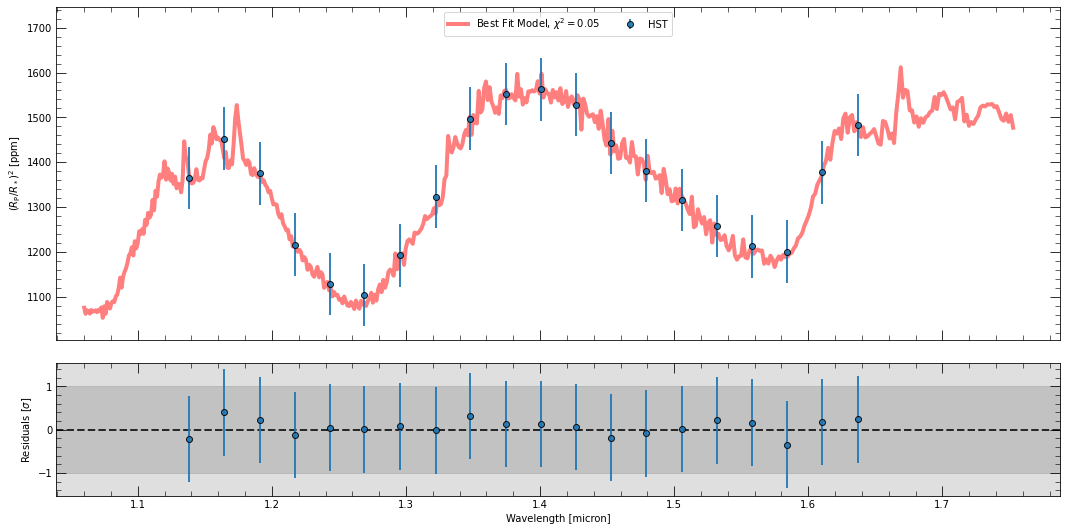

In [19]:
# Plotting the best fit spectrum
# This will generate a few warnings, but it's fine.
fig,ax,ax_r = retrieval.plot_spectra(samples_use, parameters_read, refresh = True, mode = 'bestfit')
plt.show()

/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:121: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  FutureWarning)



Plotting PT profiles
Best fit likelihood = 172.62
Best fit likelihood = 172.62
  Read line opacities of CH4...
 Done.
  Read line opacities of H2O_Exomol...
 Done.
  Read line opacities of CO2...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



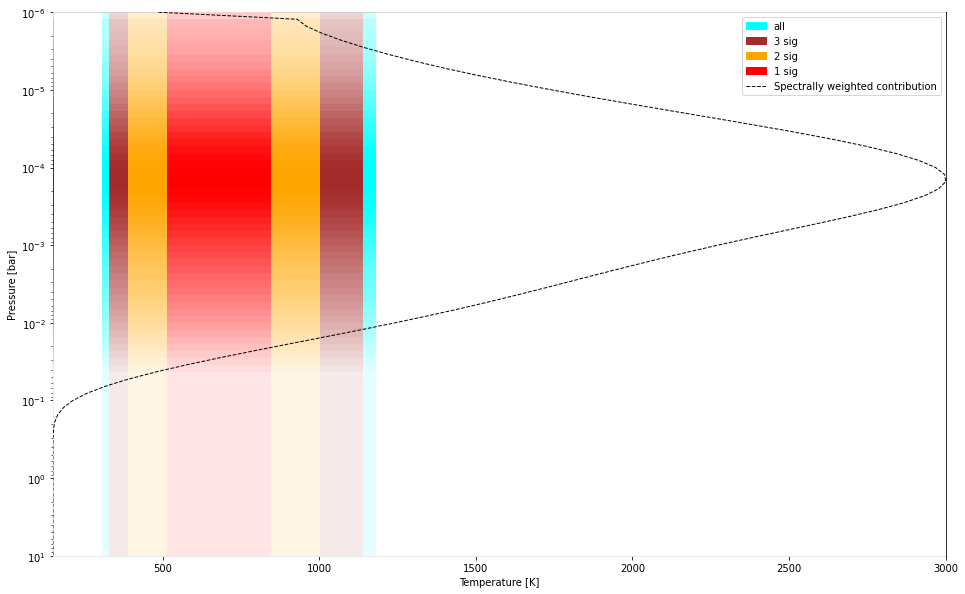

In [20]:
# Plotting the PT profile
fig,ax =retrieval.plot_PT(sample_dict,parameters_read, contribution = True)
plt.show()

/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(2014, 9)

Making corner plot


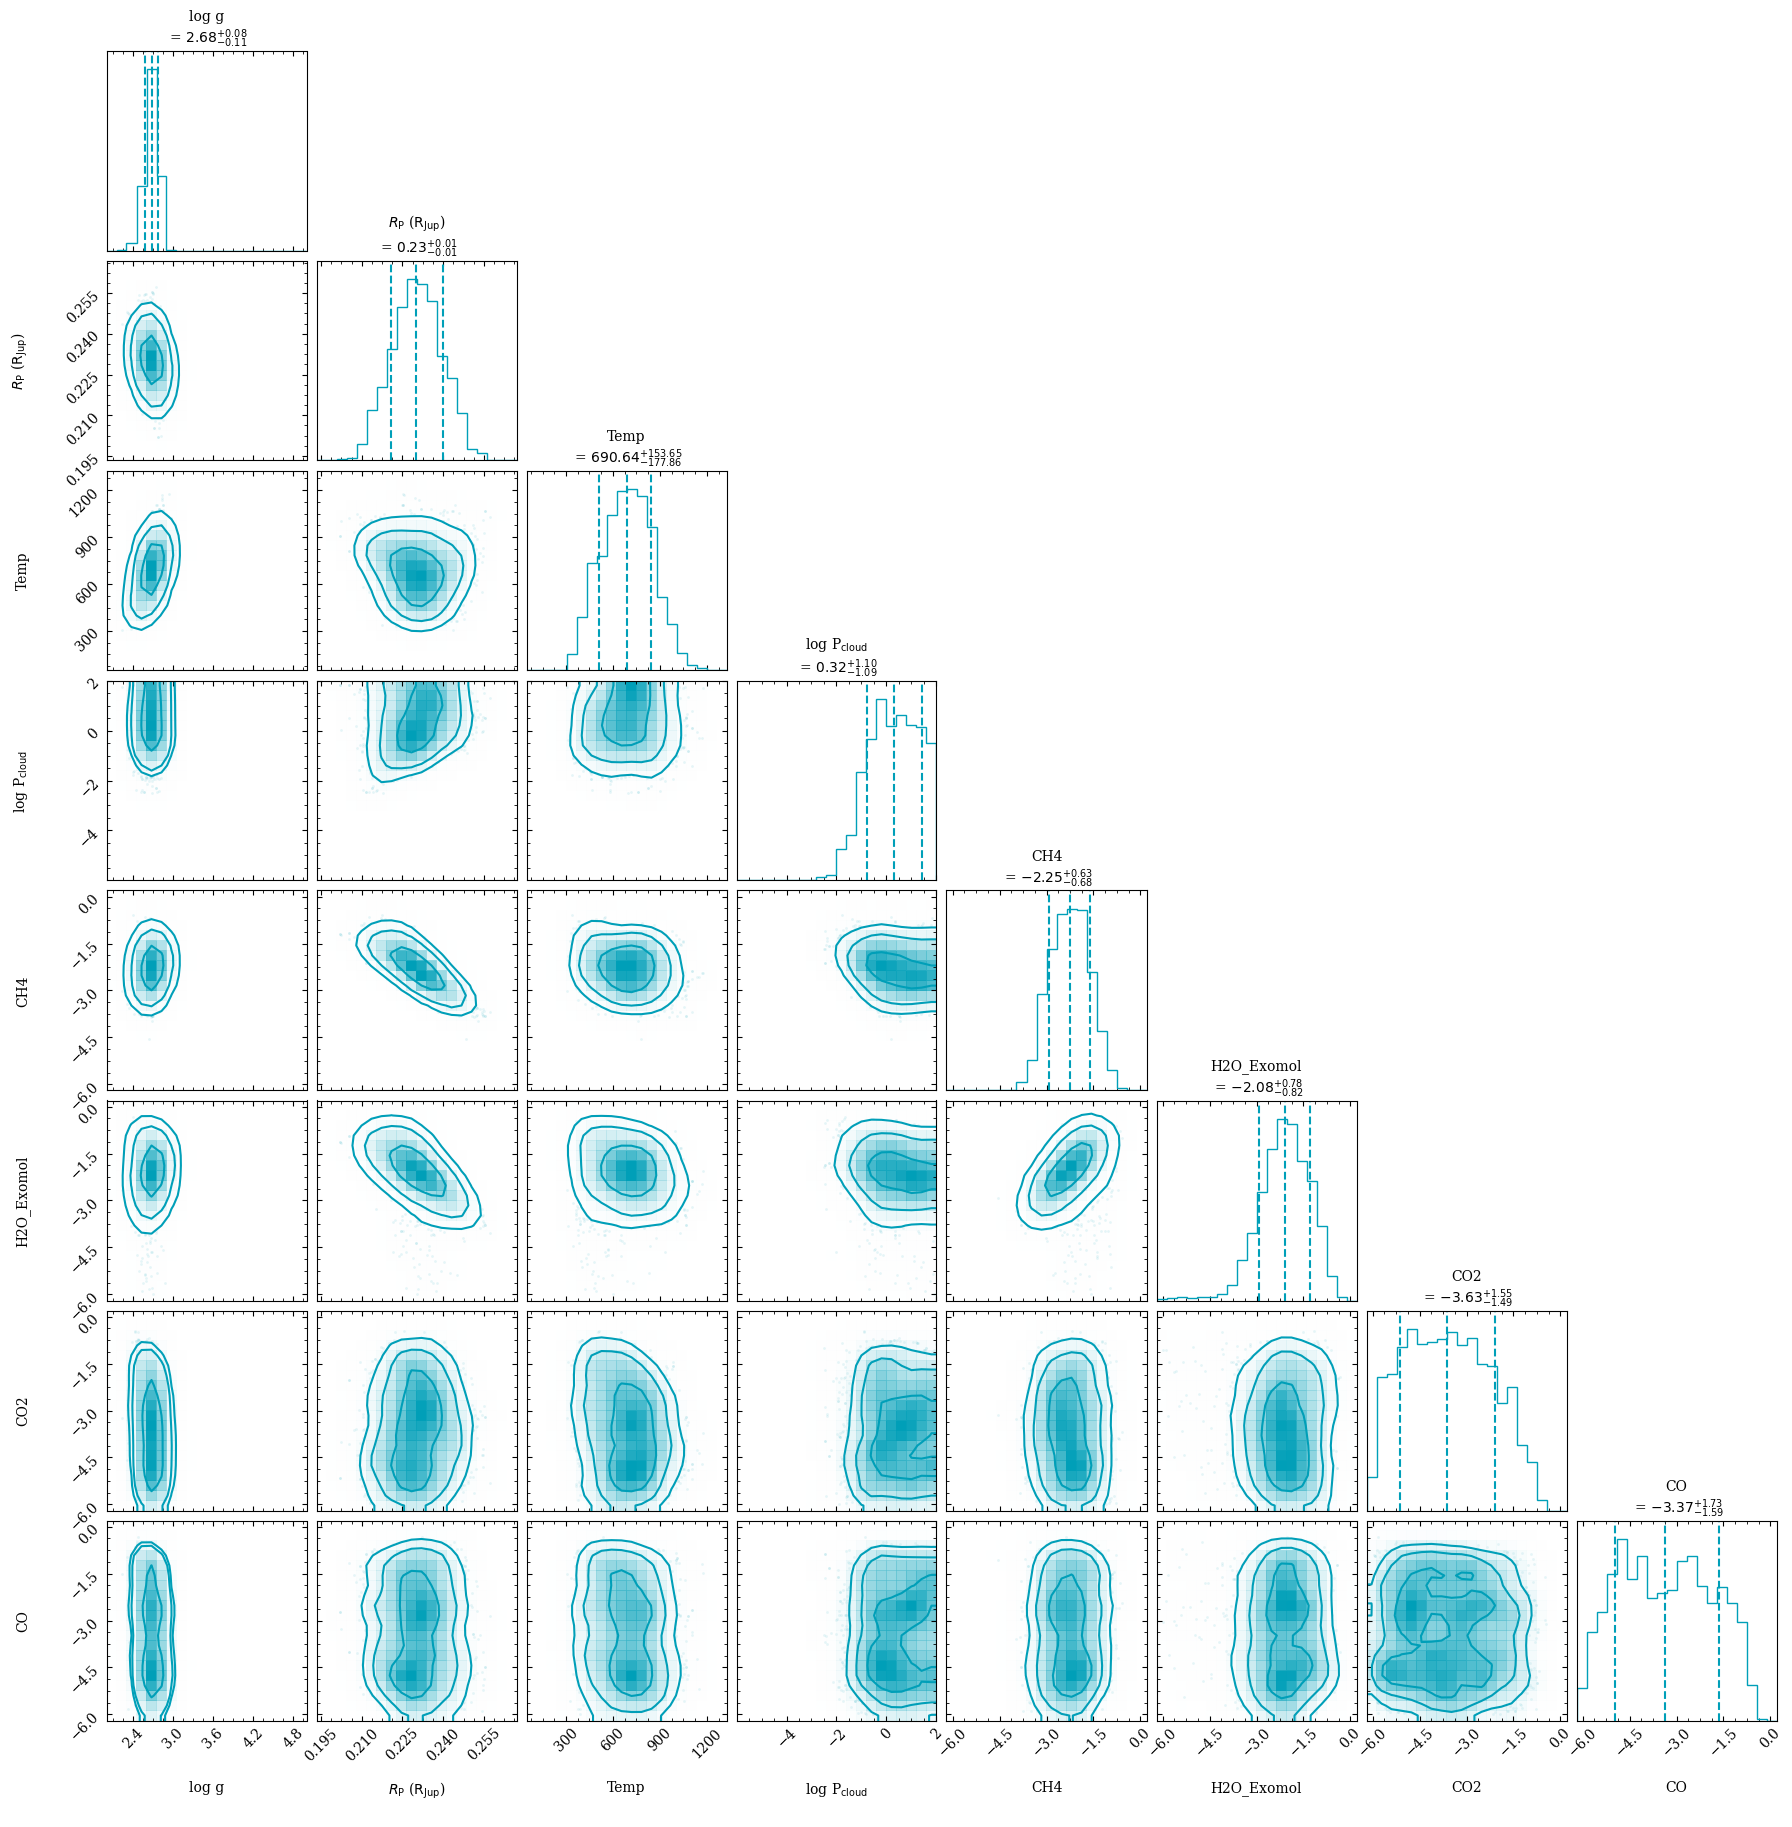

In [21]:
# Corner plot
# The corner plot produces 1,2 and 3 sigma contours for the 2D plots
retrieval.plot_corner(sample_dict,parameter_dict,parameters_read,title_kwargs = {"fontsize" : 10})
plt.show()

**Contact**

If you need any additional help, don't hesitate to contact [Evert Nasedkin](mailto:nasedkinevert@gmail.com?subject=[petitRADTRANS]%20Retrievals).